In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import show
import os
from io import StringIO

cwd = os.getcwd() # Get direction

In [2]:
import json
import requests
from urllib.request import urlopen
import plotly.express as px

### Function to generate dataframe from USDA API

In [3]:
# http direction 
nass_base = 'http://quickstats.nass.usda.gov/api/api_GET?'
# My personal key
key= '1897574B-86B2-3182-B9C3-3BFF302E3042'

def api_nass(api_params, key):
    apidata = requests.get(nass_base, params=api_params)
    apidata = apidata.json()
    df = pd.DataFrame.from_dict(apidata['data'])
    return df

### Function to append especific variables for several years by "area operated" from Ag Census. 
#### Returns dataframe with time series format

In [4]:
area_params = {'key': key,
                       'sector_desc': 'ECONOMICS',
                       'commodity_desc': 'PRACTICES',
                       'domain_desc': 'AREA OPERATED',
                       'short_desc': 'PRACTICES, LAND USE, DRAINED BY TILE - ACRES',
                       'agg_level_desc': 'STATE',
                       'year': 2022}
df= api_nass(area_params, key)

In [5]:
def dataframe_usda(varlist,key, years, sector ,commodity,domain,geolevel, separ, label_index):
    dfA = pd.DataFrame(columns=['year','state_fips_code','state_name','domaincat_desc'])

    for z in varlist:
        label= z.split(separ)[label_index]
        dfB = pd.DataFrame()
        for y in years:
            # Parameters for land tenure data
            area_params = {'key': key,
                       'sector_desc': sector,
                       'commodity_desc': commodity,
                       'domain_desc': domain,
                       'short_desc': z,
                       'agg_level_desc': geolevel.upper(),
                       'year': y}
            df= api_nass(area_params, key)
            df[label]= df['Value'].str.replace(',', '')
            df[label]= pd.to_numeric(df[label], errors='coerce')
            df[label].replace(np.nan, 'D', inplace=True) #These are rows without enough obs 'D'

            # merge number of operations (farms) with area

            filt=['year','state_name','state_fips_code','domaincat_desc',label]

            dfB=dfB.append(df[filt], 'sort=False') #append years

        dfA=dfA.merge(dfB, how='outer', on=['year','state_fips_code','state_name','domaincat_desc']) #merge vars          

    return dfA

### Data on precipitation-adaptation practices

In [6]:
pract_acre=['PRACTICES, LAND USE, CROPLAND, COVER CROP PLANTED, (EXCL CRP) - ACRES',
           'PRACTICES, LAND USE, DRAINED BY TILE - ACRES']

pract_ope=['PRACTICES, LAND USE, CROPLAND, COVER CROP PLANTED, (EXCL CRP) - NUMBER OF OPERATIONS',
          'PRACTICES, LAND USE, DRAINED BY TILE - NUMBER OF OPERATIONS']
dfprac= dataframe_usda(pract_acre+pract_ope,key,[2012,2017,2022],'ECONOMICS','PRACTICES','AREA OPERATED','state',separ=', ',label_index=-1) #dataframe of practices in agriculture

In [7]:
dfprac= dfprac[dfprac['state_name']!= 'ALASKA']
dfprac= dfprac[dfprac['state_name']!= 'HAWAII']
dfprac.replace(np.nan, 0, inplace=True)

In [8]:
dfprac

,year,state_name,state_fips_code,domaincat_desc,(EXCL CRP) - ACRES,DRAINED BY TILE - ACRES,(EXCL CRP) - NUMBER OF OPERATIONS,DRAINED BY TILE - NUMBER OF OPERATIONS
0,2012,ALABAMA,01,"AREA OPERATED: (1,000 TO 1,999 ACRES)",51652,8750,148.0,69.0
2,2012,ARIZONA,04,"AREA OPERATED: (1,000 TO 1,999 ACRES)",3908,D,13.0,6.0
3,2012,ARKANSAS,05,"AREA OPERATED: (1,000 TO 1,999 ACRES)",34967,121994,85.0,123.0
4,2012,CALIFORNIA,06,"AREA OPERATED: (1,000 TO 1,999 ACRES)",56062,77528,140.0,135.0
5,2012,COLORADO,08,"AREA OPERATED: (1,000 TO 1,999 ACRES)",27217,15089,144.0,54.0
...,...,...,...,...,...,...,...,...
1784,2022,WISCONSIN,55,AREA OPERATED: (70.0 TO 99.9 ACRES),10744,15895,594.0,505.0
1785,2022,WYOMING,56,AREA OPERATED: (70.0 TO 99.9 ACRES),638,817,20.0,19.0
1786,2012,MASSACHUSETTS,25,"AREA OPERATED: (2,000 OR MORE ACRES)",0,D,0.0,1.0
1788,2017,MASSACHUSETTS,25,"AREA OPERATED: (2,000 OR MORE ACRES)",0,D,0.0,1.0


In [9]:
A= ['(EXCL CRP) - ACRES',
     'DRAINED BY TILE - ACRES',
    '(EXCL CRP) - NUMBER OF OPERATIONS',
       'DRAINED BY TILE - NUMBER OF OPERATIONS']
df=dfprac[A]
df.dropna(how='all')

,(EXCL CRP) - ACRES,DRAINED BY TILE - ACRES,(EXCL CRP) - NUMBER OF OPERATIONS,DRAINED BY TILE - NUMBER OF OPERATIONS
0,51652,8750,148.0,69.0
2,3908,D,13.0,6.0
3,34967,121994,85.0,123.0
4,56062,77528,140.0,135.0
5,27217,15089,144.0,54.0
...,...,...,...,...
1784,10744,15895,594.0,505.0
1785,638,817,20.0,19.0
1786,0,D,0.0,1.0
1788,0,D,0.0,1.0


### Data of land size categories

In [70]:
#cat=['AG LAND, CROPLAND, HARVESTED - ACRES','AG LAND, CROPLAND, HARVESTED - NUMBER OF OPERATIONS']
#dfland= dataframe_usda(cat,key, [2012,2017,2022], 'ECONOMICS','AG LAND','AREA OPERATED','state',separ='- ',label_index=-1)
cat= ['FARM OPERATIONS - ACRES OPERATED', 'FARM OPERATIONS - NUMBER OF OPERATIONS']
dfland= dataframe_usda(cat,key, [2012,2017,2022], 'ECONOMICS','FARM OPERATIONS','AREA OPERATED','state',separ='- ',label_index=-1)


In [71]:
## Clean data
#Select categories
selection=['AREA OPERATED: (1,000 TO 1,999 ACRES)',
       'AREA OPERATED: (1.0 TO 9.9 ACRES)',
       'AREA OPERATED: (10.0 TO 49.9 ACRES)',
       'AREA OPERATED: (100 TO 139 ACRES)',
       'AREA OPERATED: (140 TO 179 ACRES)',
       'AREA OPERATED: (180 TO 219 ACRES)',
       'AREA OPERATED: (2,000 OR MORE ACRES)',
       'AREA OPERATED: (220 TO 259 ACRES)',
       'AREA OPERATED: (260 TO 499 ACRES)',
       'AREA OPERATED: (50.0 TO 69.9 ACRES)',
       'AREA OPERATED: (500 TO 999 ACRES)',
       'AREA OPERATED: (70.0 TO 99.9 ACRES)']
# New dataset with selected categories of land size    
dfland1= dfland.loc[dfland['domaincat_desc'].isin(selection)]
#### Define upper and lower bounds of land size tabulated data
# Extract numbers (acres) from column: categories description
dfland1['farmcat']=dfland1['domaincat_desc']
dfland1['farmcat']= dfland1['farmcat'].str.replace(',', '', regex=True)
dfland1['farmcat']= dfland1['farmcat'].str.replace('.0', '', regex=False)
dfland1['farmcat']= dfland1['farmcat'].str.replace('.9', '', regex=False)

dfs = dfland1['farmcat'].str.findall('\d+').to_frame()
dfland1['lower_bound']= dfs.apply(lambda x: x.str[0])
dfland1['upper_bound']= dfs.apply(lambda x: x.str[1])

dfland1['lower_bound']=dfland1['lower_bound'].astype(int)
dfland1['upper_bound']=pd.to_numeric(dfland1['upper_bound'], errors='coerce')
#dfland1['upper_bound'].astype(int)


/Users/elizabethespinosa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/elizabethespinosa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/elizabethespinosa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [72]:
dfland1= dfland1[dfland1['state_name']!= 'ALASKA']
dfland1= dfland1[dfland1['state_name']!= 'HAWAII']

### Data on policies in terms of land area

In [12]:
varlist= ['AG LAND, CROP INSURANCE - ACRES','AG LAND, CROP INSURANCE - NUMBER OF OPERATIONS','AG LAND, IRRIGATED - NUMBER OF OPERATIONS',
         'AG LAND, RENTED FROM OTHERS, IN FARMS - ACRES','AG LAND, RENTED FROM OTHERS, IN FARMS - NUMBER OF OPERATIONS',
         'AG LAND, OWNED, IN FARMS - ACRES','AG LAND, OWNED, IN FARMS - NUMBER OF OPERATIONS']
dfcrop= dataframe_usda(varlist,key, [2012,2017,2022], 'ECONOMICS','AG LAND','AREA OPERATED','state',separ=', ',label_index=1)


In [13]:
## irrigated land in acres (only cropland)
varlist= ['AG LAND, CROPLAND, HARVESTED, IRRIGATED - ACRES','AG LAND, CROPLAND, HARVESTED, IRRIGATED - NUMBER OF OPERATIONS']
dfirr= dataframe_usda(varlist,key, [2012,2017, 2022], 'ECONOMICS','AG LAND','AREA OPERATED','state',separ=', ',label_index=3)


###  Data on business operations: income and expenses

In [14]:
## Variable list of farm operations grouped by 'commodity(labor, feed, etc)' description
varlist = [['INCOME, NET CASH FARM, OF OPERATIONS - NET INCOME, MEASURED IN $ / OPERATION'], #net income
       ['GOVT PROGRAMS, FEDERAL - RECEIPTS, MEASURED IN $','GOVT PROGRAMS, FEDERAL - OPERATIONS WITH RECEIPTS'], #federal programs
       ['LABOR, HIRED - EXPENSE, MEASURED IN $'],#labor
          ['INCOME, FARM-RELATED - RECEIPTS, MEASURED IN $','INCOME, FARM-RELATED - OPERATIONS WITH RECEIPTS', # farm-related income
          'INCOME, FARM-RELATED, GOVT PROGRAMS, STATE & LOCAL - RECEIPTS, MEASURED IN $', # local and state government transfers
           'INCOME, FARM-RELATED, GOVT PROGRAMS, STATE & LOCAL - OPERATIONS WITH RECEIPTS']
          #['FERTILIZER TOTALS, INCL LIME & SOIL CONDITIONERS - EXPENSE, MEASURED IN $', #fertilizer
           #'FERTILIZER TOTALS, INCL LIME & SOIL CONDITIONERS - OPERATIONS WITH EXPENSE'],
        "LABOR, CONTRACT - EXPENSE, MEASURED IN $",'LABOR, CONTRACT - OPERATIONS WITH EXPENSE',
           #['SEEDS & PLANTS TOTALS - EXPENSE, MEASURED IN $','SEEDS & PLANTS TOTALS - OPERATIONS WITH EXPENSE'],
       ['RENT, CASH, LAND & BUILDINGS - EXPENSE, MEASURED IN $',"RENT, CASH, LAND & BUILDINGS - OPERATIONS WITH EXPENSE"],
      #['FUELS, INCL LUBRICANTS - EXPENSE, MEASURED IN $','FUELS, INCL LUBRICANTS - OPERATIONS WITH EXPENSE'],
      ['EXPENSE TOTALS, OPERATING - EXPENSE, MEASURED IN $','EXPENSE TOTALS, OPERATING - OPERATIONS WITH EXPENSE'],
      #['CHEMICAL TOTALS - EXPENSE, MEASURED IN $','CHEMICAL TOTALS - OPERATIONS WITH EXPENSE'],
        #['FEED - OPERATIONS WITH EXPENSE',],
      #['EXPENSE TOTALS, OPERATING - EXPENSE, MEASURED IN $ / OPERATION'],
      #['CCC LOANS - RECEIPTS, MEASURED IN $','CCC LOANS - OPERATIONS WITH RECEIPTS']
          ]

commodity = ['INCOME, NET CASH FARM','GOVT PROGRAMS','LABOR','INCOME, FARM-RELATED']
             #,'CCC LOANS','LABOR','SEEDS & PLANTS TOTALS','RENT','FUELS','EXPENSE TOTALS','CHEMICAL TOTALS','FEED','FERTILIZER TOTALS','EXPENSE TOTALS',]


SyntaxError: invalid syntax (<ipython-input-14-8fbd1f9f2691>, line 10)

In [15]:
varlist = ['INCOME, NET CASH FARM, OF OPERATIONS - NET INCOME, MEASURED IN $ / OPERATION']
dfy= dataframe_usda(varlist,key, [2012,2017, 2022], 'ECONOMICS','INCOME, NET CASH FARM','AREA OPERATED','state',separ='- ',label_index=1)


In [16]:
varlist = ['GOVT PROGRAMS, FEDERAL - RECEIPTS, MEASURED IN $','GOVT PROGRAMS, FEDERAL - OPERATIONS WITH RECEIPTS']
dfg= dataframe_usda(varlist,key, [2012,2017, 2022], 'ECONOMICS','GOVT PROGRAMS','AREA OPERATED','state',separ=', ',label_index=1)


In [17]:
varlist = ['INCOME, FARM-RELATED - RECEIPTS, MEASURED IN $','INCOME, FARM-RELATED - OPERATIONS WITH RECEIPTS', # farm-related income
          ]
dfyf= dataframe_usda(varlist,key, [2012,2017, 2022], 'ECONOMICS','INCOME, FARM-RELATED','AREA OPERATED','state',separ=', ',label_index=1)


In [18]:
varlist= ['INCOME, FARM-RELATED, GOVT PROGRAMS, STATE & LOCAL - RECEIPTS, MEASURED IN $', # local and state government transfers
           'INCOME, FARM-RELATED, GOVT PROGRAMS, STATE & LOCAL - OPERATIONS WITH RECEIPTS']
dfyf1= dataframe_usda(varlist,key, [2012,2017, 2022], 'ECONOMICS','INCOME, FARM-RELATED','AREA OPERATED','state',separ=', ',label_index=3)


In [19]:
varlist=['LABOR, HIRED - EXPENSE, MEASURED IN $', 'LABOR, HIRED - OPERATIONS WITH EXPENSE',
       "LABOR, CONTRACT - EXPENSE, MEASURED IN $",'LABOR, CONTRACT - OPERATIONS WITH EXPENSE']
dfl= dataframe_usda(varlist,key, [2012,2017, 2022], 'ECONOMICS','LABOR','AREA OPERATED','state',separ=', ',label_index=1)


In [20]:
varlist= ['RENT, CASH, LAND & BUILDINGS - EXPENSE, MEASURED IN $',"RENT, CASH, LAND & BUILDINGS - OPERATIONS WITH EXPENSE"]
dfre= dataframe_usda(varlist,key, [2012,2017, 2022], 'ECONOMICS','RENT','AREA OPERATED','state',separ=', ',label_index=2)


In [21]:
varlist= ['EXPENSE TOTALS, OPERATING - EXPENSE, MEASURED IN $','EXPENSE TOTALS, OPERATING - OPERATIONS WITH EXPENSE']
dfex= dataframe_usda(varlist,key, [2012,2017, 2022], 'ECONOMICS','EXPENSE TOTALS','AREA OPERATED','state',separ='- ',label_index=1)


In [22]:
dfre

,year,state_name,state_fips_code,domaincat_desc,LAND & BUILDINGS - EXPENSE,LAND & BUILDINGS - OPERATIONS WITH EXPENSE
0,2012,ALABAMA,01,"AREA OPERATED: (1,000 TO 1,999 ACRES)",2.3078e+07,507
1,2012,ALASKA,02,"AREA OPERATED: (1,000 TO 1,999 ACRES)",61000,7
2,2012,ARIZONA,04,"AREA OPERATED: (1,000 TO 1,999 ACRES)",2.5654e+07,250
3,2012,ARKANSAS,05,"AREA OPERATED: (1,000 TO 1,999 ACRES)",5.4095e+07,993
4,2012,CALIFORNIA,06,"AREA OPERATED: (1,000 TO 1,999 ACRES)",2.43963e+08,1294
...,...,...,...,...,...,...
1789,2022,VIRGINIA,51,AREA OPERATED: (70.0 TO 99.9 ACRES),3.478e+06,524
1790,2022,WASHINGTON,53,AREA OPERATED: (70.0 TO 99.9 ACRES),5.479e+06,263
1791,2022,WEST VIRGINIA,54,AREA OPERATED: (70.0 TO 99.9 ACRES),351000,128
1792,2022,WISCONSIN,55,AREA OPERATED: (70.0 TO 99.9 ACRES),9.191e+06,1019


### Data on access to machinery

In [23]:
varlist= ['MACHINERY TOTALS - ASSET VALUE, MEASURED IN $', 'MACHINERY TOTALS - OPERATIONS WITH ASSET VALUE']
dfmach= dataframe_usda(varlist,key, [2012,2017, 2022], 'ECONOMICS','MACHINERY TOTALS','AREA OPERATED','state',separ=' - ',label_index=0)


### Data on operations by NAICS and farm size

In [24]:
varlist= ['FARM OPERATIONS - NUMBER OF OPERATIONS']
dfnaics= dataframe_usda(varlist,key,[2012,2017, 2022], 'ECONOMICS','FARM OPERATIONS','AREA OPERATED AND NAICS CLASSIFICATION','state',separ=' - ',label_index=0)

In [25]:
dfnaics['domain']= dfnaics['domaincat_desc']
dfnaics['naics']= dfnaics['domain'].str.split(' AND ').str[1]
dfnaics['domaincat_desc']= dfnaics['domain'].str.split(' AND ').str[0]


In [28]:

## Quantify operations practicing main agricultural activities
dfnaics['grains']= np.where(dfnaics['naics']=='NAICS CLASSIFICATION: (1111)', 1, 0)
dfnaics['veggies']= np.where(dfnaics['naics']=='NAICS CLASSIFICATION: (1112)', 1, 0)
dfnaics['fruit']= np.where(dfnaics['naics']=='NAICS CLASSIFICATION: (1113)', 1, 0)
dfnaics['cattle']= np.where(dfnaics['naics']=='NAICS CLASSIFICATION: (112111)', 1, 0)

for x in ['grains','veggies','fruit','cattle']:
    dfnaics[x] = dfnaics[x]* dfnaics['FARM OPERATIONS'] #get number of farms in each agric code

dfic= dfnaics.groupby(['year','state_fips_code','domaincat_desc'])['grains','veggies','fruit','cattle'].max().reset_index()


In [29]:
dfic

,year,state_fips_code,domaincat_desc,grains,veggies,fruit,cattle
0,2012,01,"AREA OPERATED: (1,000 TO 1,999 ACRES)",127,4,13,291
1,2012,01,AREA OPERATED: (1.0 TO 9.9 ACRES),40,233,216,643
2,2012,01,AREA OPERATED: (10.0 TO 49.9 ACRES),327,475,489,4959
3,2012,01,AREA OPERATED: (100 TO 139 ACRES),148,83,106,2013
4,2012,01,AREA OPERATED: (140 TO 179 ACRES),136,45,78,1340
...,...,...,...,...,...,...,...
1795,2022,56,AREA OPERATED: (220 TO 259 ACRES),9,0,0,85
1796,2022,56,AREA OPERATED: (260 TO 499 ACRES),75,1,0,350
1797,2022,56,AREA OPERATED: (50.0 TO 69.9 ACRES),13,2,0,128
1798,2022,56,AREA OPERATED: (500 TO 999 ACRES),63,0,1,406


### Weather and Climate Data NOAA

In [30]:
## from csv data
dfh= pd.read_csv(cwd[:-4]+'Data/noaaclimate_county_1987_2022_growingseason.csv')

In [31]:
# Define time windows 
# Baseline: 1987-2007
# 3 periods: 2008-2012; 2013-2017; 2018-2022
condlist= [(dfh['year']<=2007), 
           ((dfh['year']>2007) & (dfh['year']<2013)), 
          ((dfh['year']>2012) & (dfh['year']<2018)), 
           (dfh['year']>2017)]
choicelist=[0, 1, 2, 3]
dfh['base'] = np.select(condlist, choicelist, np.nan)


In [32]:
dfh['county_fips']= dfh['county_fips'].astype(str)
dfh['county_fips']= dfh['county_fips'].str.zfill(5)
dfh['state_fips']= dfh['county_fips'].str[:-3]
dfh['county_ansi']= dfh['county_fips'].str[-3:]

In [33]:
# Recode states and counties
condlist= [(dfh['state_fips']== '01'), (dfh['state_fips']== '02'), (dfh['state_fips']== '03'), (dfh['state_fips']== '04'),
          (dfh['state_fips']== '05'), (dfh['state_fips']== '06'), (dfh['state_fips']== '07'), (dfh['state_fips']== '08'),
           (dfh['state_fips']== '09'), (dfh['state_fips']== '10'), (dfh['state_fips']== '11'), (dfh['state_fips']== '12'),
           (dfh['state_fips']== '13'), (dfh['state_fips']== '14'), (dfh['state_fips']== '15'), (dfh['state_fips']== '16'),
           (dfh['state_fips']== '17'), (dfh['state_fips']== '18'), (dfh['state_fips']== '19'), (dfh['state_fips']== '20'),
           (dfh['state_fips']== '21'), (dfh['state_fips']== '22'), (dfh['state_fips']== '23'), (dfh['state_fips']== '24'),
           (dfh['state_fips']== '25'), (dfh['state_fips']== '26'), (dfh['state_fips']== '27'), (dfh['state_fips']== '28'),
           (dfh['state_fips']== '29'), (dfh['state_fips']== '30'), (dfh['state_fips']== '31'), (dfh['state_fips']== '32'),
           (dfh['state_fips']== '33'), (dfh['state_fips']== '34'), (dfh['state_fips']== '35'), (dfh['state_fips']== '36'),
           (dfh['state_fips']== '37'), (dfh['state_fips']== '38'), (dfh['state_fips']== '39'), (dfh['state_fips']== '40'),
           (dfh['state_fips']== '41'), (dfh['state_fips']== '42'), (dfh['state_fips']== '43'), (dfh['state_fips']== '44'),           
           (dfh['state_fips']== '45'), (dfh['state_fips']== '46'), (dfh['state_fips']== '47'), (dfh['state_fips']== '48')          
          ]
choicelist=['01','04','05','06','08','09','10','12','13','16','17','18','19','20','21','22','23','24','25','26',
           '27','28','29','30','31','32','33','34','35','36','37','38','39','40','41','42','44','45','46','47',
           '48','49','50','51','53','54','55','56']
dfh['state_ansi'] = np.select(condlist, choicelist, np.nan)
dfh['county_fips']= dfh['state_ansi']+dfh['county_ansi']


In [34]:
## Compute averages and standard deviations
dfm= dfh.iloc[:,1:].groupby(['county_fips','base']).agg({'tavg':{'tavg_mean': 'mean', 'tavg_std': 'std'},
      'edd':{'edd_mean': 'mean', 'edd_std': 'std'}, 'pcp_mm':{'pcp_mm_mean': 'mean', 'pcp_mm_std': 'std'},
      'pcp_days':{'pcpdays_mean': 'mean', 'pcpdays_std': 'std'}}).reset_index()
## Clean column names
dfm.columns.set_levels(['county_fips','base','tavg_mean','tavg_std','edd_mean','edd_std',
                      'pcp_mm_mean', 'pcp_mm_std','pcpdays_mean','pcpdays_std'],level=1,inplace=True)
dfm.columns= dfm.columns.droplevel(1)
dfm.set_axis(['county_fips','base','tavg_mean','tavg_std','edd_mean','edd_std',
                      'pcp_mm_mean', 'pcp_mm_std','pcpdays_mean','pcpdays_std'], axis=1, inplace=True)

/Users/elizabethespinosa/opt/anaconda3/lib/python3.7/site-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


In [35]:
## Split dataframe: base versus period
dfb= dfm[dfm['base']==0.0]
dfm= dfm[dfm['base']>0.0]
dfb.rename(columns= {'tavg_mean': 'tavg_mean_base' ,'tavg_std': 'tavg_std_base', 'edd_mean': 'edd_mean_base',
                     'edd_std': 'edd_std_base', 'pcp_mm_mean': 'pcp_mm_mean_base', 'pcp_mm_std': 'pcp_mm_std_base', 
                     'pcpdays_mean': 'pcpdays_mean_base', 'pcpdays_std': 'pcpdays_std_base'}, inplace=True)
dfb= dfb[['county_fips','tavg_mean_base', 'tavg_std_base',
       'edd_mean_base', 'edd_std_base', 'pcp_mm_mean_base', 'pcp_mm_std_base',
       'pcpdays_mean_base', 'pcpdays_std_base']]
dfm= pd.merge(dfm, dfb)
dfm['state_fips_code']= dfm['county_fips'].str[:-3]


In [36]:
dfm.iloc[:,2:]

,tavg_mean,tavg_std,edd_mean,edd_std,pcp_mm_mean,pcp_mm_std,pcpdays_mean,pcpdays_std,tavg_mean_base,tavg_std_base,edd_mean_base,edd_std_base,pcp_mm_mean_base,pcp_mm_std_base,pcpdays_mean_base,pcpdays_std_base,state_fips_code
0,24.383425,0.678696,135.0,11.247222,1384.546,286.827225,15.2,4.658326,23.781317,0.579964,132.000000,12.024974,1346.034762,192.472847,14.047619,3.138092,01
1,24.145325,0.603948,137.2,15.287250,1430.852,169.125289,14.4,5.176872,23.781317,0.579964,132.000000,12.024974,1346.034762,192.472847,14.047619,3.138092,01
2,24.402603,0.587547,141.6,13.408952,1523.008,225.202143,15.4,1.516575,23.781317,0.579964,132.000000,12.024974,1346.034762,192.472847,14.047619,3.138092,01
3,25.267120,0.438734,139.8,6.685806,1539.874,307.421050,16.2,5.019960,24.719836,0.469496,138.857143,11.624482,1611.112857,280.287547,16.619048,4.352886,01
4,24.981601,0.527534,140.2,11.584472,1736.808,235.527836,18.6,2.607681,24.719836,0.469496,138.857143,11.624482,1611.112857,280.287547,16.619048,4.352886,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9316,15.560699,0.418598,57.0,12.288206,354.516,30.918691,0.4,0.547723,15.235477,0.869613,46.761905,15.899386,308.261429,59.638330,0.142857,0.478091,56
9317,15.408852,0.369652,60.6,11.970798,302.538,82.602679,0.4,0.547723,15.235477,0.869613,46.761905,15.899386,308.261429,59.638330,0.142857,0.478091,56
9318,15.231535,1.343594,54.6,14.205633,388.862,93.741756,0.6,0.894427,15.506046,0.878658,54.047619,14.087144,381.372857,72.372277,0.619048,0.804748,56
9319,15.541106,0.435015,56.0,4.795832,405.816,74.883392,0.8,0.836660,15.506046,0.878658,54.047619,14.087144,381.372857,72.372277,0.619048,0.804748,56


In [37]:
## Compute standard deviations and coefficients of variation from the historical averages
for var in ['tavg', 'edd', 'pcp_mm', 'pcpdays']:
    dfm[var+'_z']= (dfm[var+'_mean']- dfm[var+'_mean_base'])/dfm[var+'_std_base'] #standar deviations
    dfm[var+'_coeff']= dfm[var+'_std']/dfm[var+'_mean'] #coefficient of variation
    

In [38]:
condlist= [(dfm['base']== 1.0),  
          (dfm['base']== 2.0), 
           (dfm['base']== 3.0)]
choicelist=[2012, 2017, 2022]
dfm['year'] = np.select(condlist, choicelist, np.nan)


In [39]:
dfm['pcpdays_z'].replace(np.inf, 0, inplace=True)

In [40]:
# State averages
dfnoaa= dfm.iloc[:,2:].groupby(['state_fips_code','year']).mean().reset_index()

In [41]:
(dfnoaa==np.inf).sum()

state_fips_code      0
year                 0
tavg_mean            0
tavg_std             0
edd_mean             0
edd_std              0
pcp_mm_mean          0
pcp_mm_std           0
pcpdays_mean         0
pcpdays_std          0
tavg_mean_base       0
tavg_std_base        0
edd_mean_base        0
edd_std_base         0
pcp_mm_mean_base     0
pcp_mm_std_base      0
pcpdays_mean_base    0
pcpdays_std_base     0
tavg_z               0
tavg_coeff           0
edd_z                0
edd_coeff            0
pcp_mm_z             0
pcp_mm_coeff         0
pcpdays_z            0
pcpdays_coeff        0
dtype: int64

In [42]:
dfnoaa= dfnoaa[['state_fips_code', 'year', 'tavg_mean', 'edd_mean',
       'pcp_mm_mean', 'pcpdays_mean',
       'tavg_coeff',  'edd_coeff', 'pcp_mm_coeff','pcpdays_coeff', 
       'tavg_z', 'edd_z', 'pcp_mm_z', 'pcpdays_z']]

### Merge datasets

In [122]:
DF=pd.DataFrame()
DF= pd.merge(dfland1, dfprac, on=['year','state_fips_code','state_name','domaincat_desc'], how='left')

In [123]:
DF= pd.merge(DF, dfcrop, on=['year','state_fips_code','state_name','domaincat_desc'], how='left') #insurance, rented land
DF= pd.merge(DF, dfirr, on=['year','state_fips_code','state_name','domaincat_desc'], how='left') #irrigated cropland
DF= pd.merge(DF, dfy, on=['year','state_fips_code','state_name','domaincat_desc'], how='left') # net income
DF= pd.merge(DF, dfg, on=['year','state_fips_code','state_name','domaincat_desc'], how='left') # government programs
DF= pd.merge(DF, dfyf, on=['year','state_fips_code','state_name','domaincat_desc'], how='left') # farm income
DF= pd.merge(DF, dfyf1, on=['year','state_fips_code','state_name','domaincat_desc'], how='left')# state programs
DF= pd.merge(DF, dfl, on=['year','state_fips_code','state_name','domaincat_desc'], how='left') # labor expense
DF= pd.merge(DF, dfex, on=['year','state_fips_code','state_name','domaincat_desc'], how='left') # expense total
DF= pd.merge(DF, dfmach, on=['year','state_fips_code','state_name','domaincat_desc'], how='left') #machinery assets
DF= pd.merge(DF, dfic, on=['year','state_fips_code','domaincat_desc'], how='left') # Main agro activities
DF= pd.merge(DF, dfnoaa, on=['year','state_fips_code'], how='left') #NOAA weather and climate


In [124]:
(DF.isna()).sum()

year                                          0
state_name                                    0
state_fips_code                               0
domaincat_desc                                0
ACRES OPERATED                                0
NUMBER OF OPERATIONS                          0
farmcat                                       0
lower_bound                                   0
upper_bound                                 144
(EXCL CRP) - ACRES                            4
DRAINED BY TILE - ACRES                       4
(EXCL CRP) - NUMBER OF OPERATIONS             4
DRAINED BY TILE - NUMBER OF OPERATIONS        4
CROP INSURANCE - ACRES                        6
CROP INSURANCE - NUMBER OF OPERATIONS         6
IRRIGATED - NUMBER OF OPERATIONS_x            9
RENTED FROM OTHERS_x                          5
RENTED FROM OTHERS_y                          5
OWNED_x                                       0
OWNED_y                                       0
IRRIGATED - ACRES                       

In [125]:
DF['farmcat']=DF['domaincat_desc'].str[16:-7]
DF.replace(np.nan, 0, inplace=True)
DF.replace('D', np.nan, inplace=True)


In [139]:
DF#.dropna(subset=['(EXCL CRP) - ACRES','DRAINED BY TILE - ACRES'], how='any')

,year,state_name,state_fips_code,domaincat_desc,ACRES OPERATED,NUMBER OF OPERATIONS,farmcat,lower_bound,upper_bound,(EXCL CRP) - ACRES,...,statepay_ope,labor_expense,labor_share,machinery_asset,grains_shareope,veggies_shareope,fruit_shareope,cattle_shareope,year_2017,year_2022
48,2012,ALABAMA,01,AREA OPERATED: (1.0 TO 9.9 ACRES),14379.0,2919,1-10,1,9.0,139.0,...,0.001028,0.077132,5.259637,36.973545,0.013703,0.079822,0.073998,0.220281,0,0
96,2012,ALABAMA,01,AREA OPERATED: (10.0 TO 49.9 ACRES),362197.0,13267,10-50,10,49.0,2651.0,...,0.003693,0.047568,3.586960,37.800758,0.024648,0.035803,0.036858,0.373785,0,0
432,2012,ALABAMA,01,AREA OPERATED: (50.0 TO 69.9 ACRES),246346.0,4235,50-70,50,69.0,1984.0,...,0.005195,0.040040,2.121030,34.715225,0.037308,0.016765,0.023849,0.452893,0,0
528,2012,ALABAMA,01,AREA OPERATED: (70.0 TO 99.9 ACRES),377435.0,4605,70-100,70,99.0,2921.0,...,0.007166,0.031832,1.831556,39.152023,0.029967,0.018458,0.022150,0.488599,0,0
144,2012,ALABAMA,01,AREA OPERATED: (100 TO 139 ACRES),500043.0,4342,100-140,100,139.0,3569.0,...,0.006909,0.036771,1.839224,30.717884,0.034086,0.019116,0.024413,0.463611,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535,2022,WYOMING,56,AREA OPERATED: (220 TO 259 ACRES),55708.0,234,220-260,220,259.0,641.0,...,0.008547,0.076909,0.328539,7.886828,0.038462,0.000000,0.000000,0.363248,0,1
1583,2022,WYOMING,56,AREA OPERATED: (260 TO 499 ACRES),320538.0,887,260-500,260,499.0,2525.0,...,0.009019,0.105112,0.487556,8.916783,0.084555,0.001127,0.000000,0.394589,0,1
1679,2022,WYOMING,56,AREA OPERATED: (500 TO 999 ACRES),619090.0,882,500-1K,500,999.0,5269.0,...,0.001134,0.110806,1.464455,17.723672,0.071429,0.000000,0.001134,0.460317,0,1
1199,2022,WYOMING,56,"AREA OPERATED: (1,000 TO 1,999 ACRES)",1102112.0,798,1K-2K,1000,1999.0,6328.0,...,0.010025,0.084350,1.982757,22.068111,0.077694,0.000000,0.000000,0.527569,0,1


In [235]:
########## Region merge
df= pd.read_csv(cwd[:-4]+'/Data/data_farmclass_state.csv')
df['state_fips_code']= DF['state_fips_code'].astype(str).str.zfill(2)
list1= ['year', 'state_fips_code', 'domaincat_desc','state_abb','erosion_rate','State', 
        'Region', 'Region_fips','subregion','region_Midwest', 'region_Northeast', 'region_Pacific West',
       'region_Plains', 'region_Southeast', 'Class_Large', 'Class_Medium',
       'Class_Small', 'land_sqmi']
#DF.drop(['Unnamed: 0'], axis=1, inplace=True)
DF= pd.merge(DF, df[list1], on=['year','state_fips_code','domaincat_desc'])

### Land distribution

In [127]:
### Fill 'upper bound' with national mean values
# Replace missing values in Acres with the midpoint of the upper and lower bounds of the tabulated data of acres 
DF['upper_bound'].replace(0, 4000, inplace=True)
DF['ACRES OPERATED']= DF['ACRES OPERATED'].fillna((DF['upper_bound'])*(DF['NUMBER OF OPERATIONS']))


In [128]:
##### Share of cropland acres
DF['share_acres']= DF['ACRES OPERATED']/(DF.groupby(['year','state_fips_code'])['ACRES OPERATED'].transform('sum'))
# share of population (i.e %farms)
DF['share_farms']= DF['NUMBER OF OPERATIONS']/(DF.groupby(['year','state_fips_code'])['NUMBER OF OPERATIONS'].transform('sum'))

# Compute accumulative shares
DF= DF.sort_values(['year','state_fips_code','lower_bound'])
DF['acres_cum']= DF.groupby(['year','state_fips_code'])['share_acres'].cumsum()
DF['farms_cum']= DF.groupby(['year','state_fips_code'])['share_farms'].cumsum()

## Create a variable that measures the ratio: land share/operations (# farms) share
DF['land_concent']= DF['share_acres']/DF['share_farms']


In [138]:
DF.replace({'farmcat':{'1.0 TO 9.9': '1-10', '10.0 TO 49.9': '10-50', '50.0 TO 69.9': '50-70', '70.0 TO 99.9': '70-100', 
                     '100 TO 139': '100-140','140 TO 179': '140-180', '180 TO 219': '180-220', '220 TO 259': '220-260',
                     '260 TO 499': '260-500','500 TO 999':'500-1K', '1,000 TO 1,999': '1K-2K', '2,000 OR MORE': '>2K'}},inplace=True)
DF['class'] = DF['farmcat']
DF.replace({'class':{'1-10': 0, '10-50': 0, '50-70': 0, '70-100':0, 
                     '100-140': 1,'140-180': 1, '180-220': 1, '220-260': 1,
                     '260-500': 2, '500-1K': 2, '1K-2K': 2, '>2K': 2}},inplace=True)

DF['farm_class']= DF['class'].astype('category').map({0: 'Small', 1: 'Medium', 2: 'Large'})



### Adaptation practices

In [130]:
DF['cover_crops']= DF['(EXCL CRP) - ACRES']/DF['ACRES OPERATED']
DF['tile_ope']=DF['DRAINED BY TILE - NUMBER OF OPERATIONS']/DF['NUMBER OF OPERATIONS']
DF['irrigated_ope']= DF['IRRIGATED - NUMBER OF OPERATIONS_x']/DF['NUMBER OF OPERATIONS']

In [131]:
##### Proportion of rented land
DF['rented_land']= DF['RENTED FROM OTHERS_x']/(DF['OWNED_x']+DF['RENTED FROM OTHERS_x'])

#### Proportion of Insured land
DF['insured_farms']= DF['CROP INSURANCE - NUMBER OF OPERATIONS']/DF['NUMBER OF OPERATIONS']
DF['cropland_insured']= DF['CROP INSURANCE - ACRES']/DF['ACRES OPERATED']


### Farm Operations

In [132]:
## Create a variable 'new total operations' that takes the bigger number of operations between
# receiving income and federal transfers. 
# This variable will be used to determine the actual fed gov transf coverage with respect to farm income 
vals = []

for i, row in DF.iterrows():
    if row['FEDERAL - OPERATIONS WITH RECEIPTS'] > row['FARM-RELATED - OPERATIONS WITH RECEIPTS']:
        vals.append(row['FEDERAL - OPERATIONS WITH RECEIPTS'])
    else:
        vals.append(row['FARM-RELATED - OPERATIONS WITH RECEIPTS'])

DF['new_totoper'] = vals

In [133]:
### Income

DF.rename(columns= {'FARM-RELATED - RECEIPTS': 'tot_income'}, inplace=True)
DF.rename(columns= {'FARM-RELATED - OPERATIONS WITH RECEIPTS': 'income_ope'}, inplace=True)
### Fill 'upper bound' with national mean values
#Get mean income of large farms
DF['mean_farmincome']= DF['tot_income']/DF['income_ope']
# Get mean acres by farm class (national level)
DF['maxincome_category']= DF.groupby(['year','domaincat_desc'])['mean_farmincome'].transform('max')
# Fill upper bound
DF['mean_farmincome']= DF['mean_farmincome'].fillna(DF['maxincome_category'])
DF['tot_income']= DF['mean_farmincome']*DF['income_ope']

In [134]:

### Mean income
DF['netincome_perfarm']= DF['NET INCOME, MEASURED IN $ / OPERATION']

### Income from Government programs
DF['fed_income']= DF['FEDERAL - RECEIPTS']/DF['tot_income']

### State, local government receiving payments
DF['statepay_ope']= DF['STATE & LOCAL - OPERATIONS WITH RECEIPTS']/DF['NUMBER OF OPERATIONS']
       
### Hired Labor Expense 
DF['labor_expense']= (DF['HIRED - EXPENSE']+DF['CONTRACT - EXPENSE'])/DF['EXPENSE, MEASURED IN $']

DF['labor_share']= (DF['HIRED - EXPENSE']+DF['CONTRACT - EXPENSE'])/DF['tot_income']

### Technology in Assets
DF['machinery_asset']= (DF['MACHINERY TOTALS_x'])/DF['tot_income']


In [135]:
### Agricultural practices NAICS

for x in ['grains', 'veggies', 'fruit', 'cattle']:
    DF[x+'_shareope']= DF[x]/DF['NUMBER OF OPERATIONS']

In [62]:
##############
# Define farm-region categories
DF['farm_region']= DF[['farm class','Region']].apply('-'.join, axis=1)
DF['farm_region'].replace(to_replace=['Small-Pacific West','Small-Plains','Small-Midwest','Small-Southeast','Small-Northeast',
                                     'Medium-Pacific West','Medium-Plains','Medium-Midwest','Medium-Southeast','Medium-Northeast',
                                     'Large-Pacific West','Large-Plains','Large-Midwest','Large-Southeast','Large-Northeast'],
                         value=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], inplace=True)

DF['region']= DF['Region']
DF= pd.get_dummies(DF, columns=['region'])

DF['Class']= DF['farm_class']
DF= pd.get_dummies(DF, columns=['Class'])
DF['state_code']= DF['state_fips_code']
DF= pd.get_dummies(DF, columns=['state_code'])

# Impute maximum values on outliers
DF.loc[DF.insured_farms > 1, 'insured_farms'] = 1
DF.loc[DF['cover crops']> 0.4, 'cover crops']= 0.4

## Agricultural harvested cropland as % total state land
DF['cropland_share']= DF['acres_tot']/(DF['land_sqmi']*640)

In [136]:
# Year 2017 dummy
DF['year_2017'] = np.where(DF['year']==2017, 1, 0)
DF['year_2022'] = np.where(DF['year']==2022, 1, 0)

(array([943., 488., 160.,  70.,  17.,   9.,   1.,   0.,   1.,   2.]),
 array([0.        , 0.33327455, 0.6665491 , 0.99982365, 1.3330982 ,
        1.66637275, 1.9996473 , 2.33292184, 2.66619639, 2.99947094,
        3.33274549]),
 <a list of 10 Patch objects>)

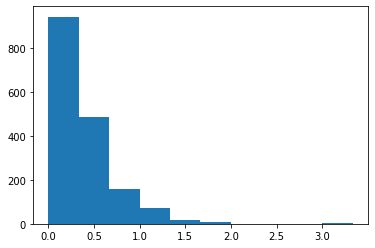

In [112]:
plt.hist(DF['fed_income'])

In [140]:
DF.to_csv(cwd[:-4]+'/Data/data_farmclass_state.csv', index=False)